In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import numpy as np
import tqdm

# custom dataloader
from src.dataloader import DIV2KDataModule
# module to get VGG features
from src.vgg_wrapper import VGGLoss
# Generator network
from src.generator import Generator
# score function
from src.training_functions import psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def bicubic_baseline(lr_image):
    """
    Upscale LR image to HR using bicubic interpolation
    Args:
        lr_image: Tensor of shape (B, C, H, W) or (C, H, W)
    Returns:
        sr_image: Upscaled image with 4x resolution
    """
    if lr_image.dim() == 3:
        lr_image = lr_image.unsqueeze(0)
    
    # Upscale 4x (64x64 -> 256x256)
    sr_image = F.interpolate(
        lr_image,
        scale_factor=4,
        mode='bicubic',
        align_corners=False
    )
    
    # Clamp to [0, 1] range
    sr_image = torch.clamp(sr_image, 0, 1)
    
    return sr_image


In [4]:
# set up dataloader
dataloader = DIV2KDataModule()
dataloader.setup()

In [6]:
# load trained model
SCALE_FACTOR = 4
G = Generator(scale_factor=SCALE_FACTOR).to(device)
G.load_state_dict(torch.load("models/generator_srgan.pth", map_location=device))
G.eval()

C:\Users\szige\AppData\Local\Temp\ipykernel_13472\4255284736.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load("models/generator_srgan.pth", m

Generator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, 

In [7]:
# test baseline
vgg_loss = VGGLoss().to(device)

# metrics
baseline_psnrs = []
srgan_psnrs = []
baseline_vgg_losses = []
srgan_vgg_losses = []

for lr_imgs, hr_imgs in dataloader.test_dataloader(batch_size=16):
    lr_imgs = lr_imgs.to(device)
    hr_imgs = hr_imgs.to(device)

    sr_baseline_imgs = bicubic_baseline(lr_imgs)
    sr_srgan_imgs = G(lr_imgs)

    psnr_baseline = psnr(sr_baseline_imgs, hr_imgs)
    baseline_psnrs.append(psnr_baseline)
    psnr_srgan = psnr(sr_srgan_imgs, hr_imgs)
    srgan_psnrs.append(psnr_srgan)

    loss_baseline = vgg_loss(sr_baseline_imgs, hr_imgs)
    baseline_vgg_losses.append(loss_baseline)
    loss_srgan = vgg_loss(sr_srgan_imgs, hr_imgs)
    srgan_vgg_losses.append(loss_srgan)

    break # do it for 1 batch, comment out for all

print(f"Bicubic Baseline PSNR: {sum(baseline_psnrs)/len(baseline_psnrs):.2f} dB")
print(f"SRGAN PSNR: {sum(srgan_psnrs)/len(srgan_psnrs):.2f} dB")
print(f"Bicubic Baseline VGG Loss: {sum(baseline_vgg_losses)/len(baseline_vgg_losses):.4f}")
print(f"SRGAN VGG Loss: {sum(srgan_vgg_losses)/len(srgan_vgg_losses):.4f}")

Bicubic Baseline PSNR: 23.78 dB
SRGAN PSNR: 22.47 dB
Bicubic Baseline VGG Loss: 7.9645
SRGAN VGG Loss: 6.4265


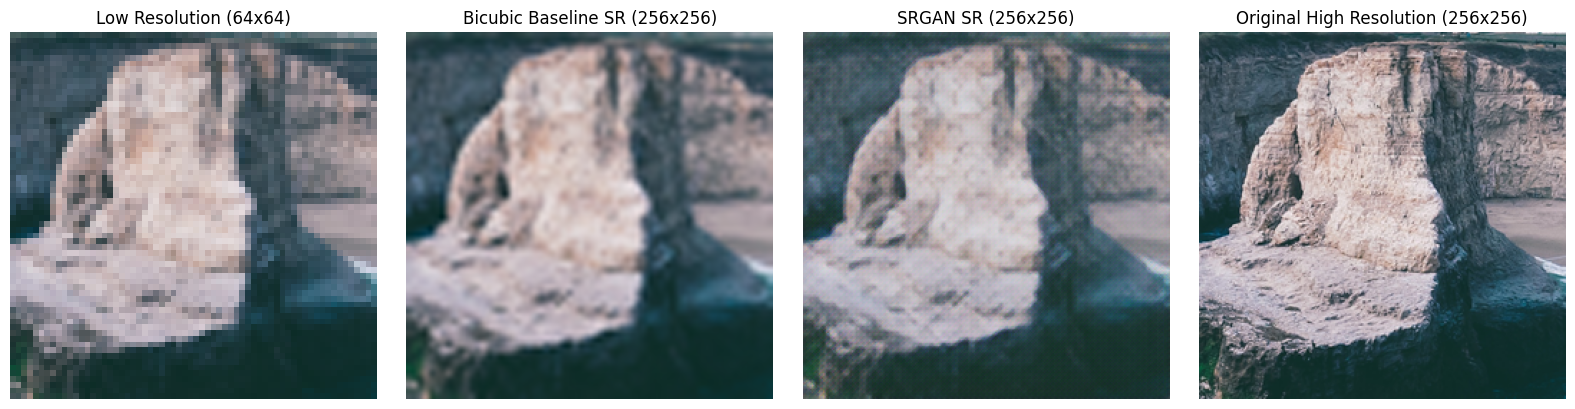

In [9]:
import matplotlib.pyplot as plt

# Select one example from the batch (e.g., first image)
idx = 6

lr_img = lr_imgs[idx].cpu().permute(1, 2, 0).numpy()
sr_baseline_img = sr_baseline_imgs[idx].cpu().permute(1, 2, 0).numpy()
sr_srgan_img = sr_srgan_imgs[idx].cpu().detach().permute(1, 2, 0).numpy()
hr_img = hr_imgs[idx].cpu().permute(1, 2, 0).numpy()

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(lr_img)
axes[0].set_title(f'Low Resolution ({lr_img.shape[0]}x{lr_img.shape[1]})')
axes[0].axis('off')

axes[1].imshow(sr_baseline_img)
axes[1].set_title(f'Bicubic Baseline SR ({sr_baseline_img.shape[0]}x{sr_baseline_img.shape[1]})')
axes[1].axis('off')

axes[2].imshow(sr_srgan_img)
axes[2].set_title(f'SRGAN SR ({sr_srgan_img.shape[0]}x{sr_srgan_img.shape[1]})')
axes[2].axis('off')

axes[3].imshow(hr_img)
axes[3].set_title(f'Original High Resolution ({hr_img.shape[0]}x{hr_img.shape[1]})')
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# GAN: train first in train_pipeline.ipynb and save it, then load it here